# 確率的勾配降下法などを用いたNNの計算

In [1]:
from  common.network import TwoLayerNet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        """
        lr : 学習係数 learning rate
        """
        self.lr = lr
        
    def update(self, params, grads):
        """
        重みの更新
        """
        for key in params.keys():
            params[key] -= self.lr * grads[key]
            
class RMSProp:
    """
    RMSProp
    """
    def __init__(self, lr=0.01, rho=0.9):
        """
        lr : 学習係数 learning rate
        rho : 減衰率
        """
        self.lr = lr
        self.h = None
        self.rho = rho
        self.epsilon = 1e-6
        
    def update(self, params, grads):
        """
        重みの更新
        """
        if self.h is None:
            """
            初回のみ
            """
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] = self.rho * self.h[key] + (1 - self.rho) * grads[key] * grads[key]          
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + self.epsilon) ) # 原著論文に合わせてepsilonをルートの中に入れる            

In [6]:
class Adagrad:
    """
    Adagrad
    """
    def __init__(self, lr=0.01):
        """
        lr : 学習係数 learning rate
        """
        self.lr = lr
        self.h = None
        self.epsilon = 1e-7
        
    def update(self, params, grads):
        """
        重みの更新
        """
        if self.h is None:
            """
            初回のみ
            """
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]          
            params[key] -= self.lr * grads[key] / (self.epsilon + np.sqrt(self.h[key]) )

In [7]:
class Adadelta:
    """
    Adadelta
    """
    def __init__(self, rho=0.95):
        """
        rho : 減衰率
        """
        self.h = None
        self.r = None        
        self.rho = rho
        self.epsilon = 1e-6
        
    def update(self, params, grads):
        """
        重みの更新
        """
        if self.h is None:
            """
            初回のみ
            """
            self.h = {}
            self.r = {}            
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                self.r[key] = np.zeros_like(val)
                
        for key in params.keys():
            
            # 1ステップ前における更新量の2乗の移動平均のルートを求める
            rms_param = np.sqrt(self.r[key] + self.epsilon)
                        
            # 勾配の2乗の移動平均を求める
            self.h[key] = self.rho * self.h[key] + (1 - self.rho) * grads[key] * grads[key]  
            
            # 勾配の2乗の移動平均のルートを求める
            rms_grad =  np.sqrt(self.h[key] + self.epsilon)
            
            # 更新量の算出
            dp = - rms_param / rms_grad * grads[key]             
            
            # 重みの更新
            params[key] += dp
            
            # 次ステップのために、更新量の2乗の移動平均を求める 
            self.r[key]  = self.rho * self.r[key] + (1 - self.rho) * dp * dp

In [3]:
# Load the MNIST dataset
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

train = X_train/255
test = X_test/255
train = train.reshape(-1, 28*28)
test = test.reshape(-1, 28*28)
train_labels = lb.fit_transform(y_train)
test_labels = lb.fit_transform(y_test)

x_train, t_train = train, train_labels
x_test, t_test = test, test_labels

/Users/yamaokadaichi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [24]:
x = train[:1000,:]
t = train_labels[:1000,:]

epochs = 30
batch_size = 25

def run(optimizer):
    # 繰り返し回数
    xsize = x.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(np.int)

    # 2層NNのオブジェクト生成
    tnet = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(epochs):
#         print("epoch=%s"%epoch)

        # シャッフル
        idx = np.arange(xsize)
        np.random.shuffle(idx)

        for it in range(iter_num):
            """
            ランダムなミニバッチを順番に取り出す
            """
            mask = idx[batch_size*it : batch_size*(it+1)]

            # ミニバッチの生成
            x_train = x[mask]
            t_train = t[mask]

            # 勾配の計算 (誤差逆伝播法を用いる) 
            grads = tnet.gradient(x_train, t_train)

            # 更新
            optimizer.update(tnet.params, grads)

        ## 学習経過の記録

        # 訓練データにおけるloss
        train_loss.append(tnet.loss(x,  t))

        # テストデータにおけるloss
        test_loss.append(tnet.loss(test, test_labels))

        # 訓練データにて精度を確認
        train_accuracy.append(tnet.accuracy(x, t))

        # テストデータにて精度を算出
        test_accuracy.append(tnet.accuracy(test, test_labels))
        

    # lossのグラフ化
    df_log = pd.DataFrame({"train_loss":train_loss,
                 "test_loss":test_loss,
                 "train_accuracy":train_accuracy,
                 "test_accuracy":test_accuracy})
    df_log.plot()
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.show()
    
    return df_log

AdaDelta, rho= 1e-08


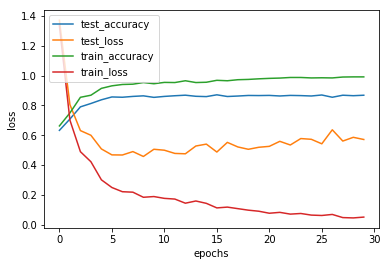

,test_accuracy,test_loss,train_accuracy,train_loss
25,0.8695,0.542031,0.985,0.061275
26,0.8544,0.636051,0.984,0.068272
27,0.8680,0.560526,0.990,0.047111
28,0.8648,0.585592,0.991,0.044933
29,0.8679,0.570985,0.991,0.050423


In [41]:
rho = 0.00000001
print("AdaDelta, rho=", rho)
optimizer = Adadelta(rho=rho)
df_log = run(optimizer)
df_log.tail()

Adagrad, lr= 2


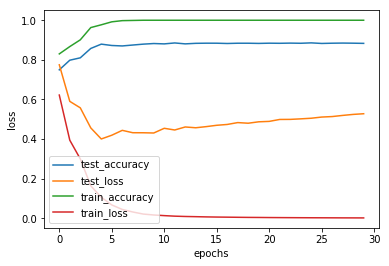

,test_accuracy,test_loss,train_accuracy,train_loss
25,0.8828,0.511031,1.0,0.002309
26,0.8840,0.513537,1.0,0.002126
27,0.8847,0.519322,1.0,0.001936
28,0.8841,0.524428,1.0,0.001817
29,0.8832,0.527825,1.0,0.001666


In [43]:
lr = 2
print("Adagrad, lr=", lr)
optimzer = Adagrad(lr=lr)
df_log = run(optimizer)
df_log.tail()

AdaDelta, rho= 0.99


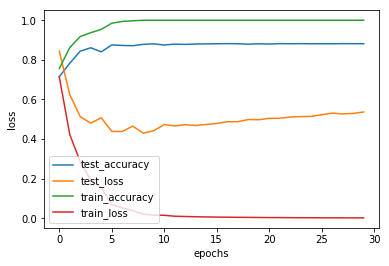

Adagrad, lr= 1e-06


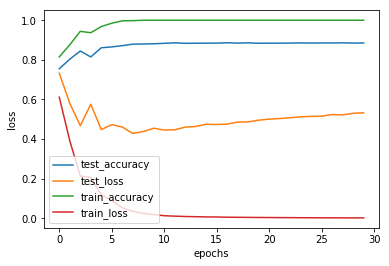

In [42]:
# 計算実行部分
# 完成したら最適化手法をいろいろ変えてみる

for  i in range(3):
    
#     if i==0:
#         print("SGD, lr=0.01")
#         optimizer = SGD(lr=0.01)
#         run(optimizer)
#     elif i==1:
#         print("SGD, lr=0.1")        
#         optimizer = SGD(lr=0.1)
#         run(optimizer)        
#     elif i==2:
#         print("RMSProp, lr=0.01, rho=0.9")        
#         optimizer = RMSProp(lr=0.01, rho=0.9)
#         run(optimizer)
    if i == 0:
        rho = 0.99
        print("AdaDelta, rho=", rho)
        optimizer = Adadelta(rho=rho)
        run(optimizer)
    elif i == 1:
        lr = 0.000001
        print("Adagrad, lr=", lr)
        optimzer = Adagrad(lr=lr)
        run(optimizer)

### [演習]
* 最適化手法を変更し、結果がどのように変わるかを確認しましょう